How to print weight for convLSTM?

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle
from ConvLSTM_pytorch import convlstm
import operator
from utils_v4 import *

# Load Data

In [2]:
#selected subset of dates. 
val_dates = ['180327','180329']
test_dates = ['180330','180331']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/'
model_saving_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models'




## Load data helper functions

In [3]:
def create_files_new(load_path, bad_dates, T_length=10, proceed=1): 
    sleep_files = os.listdir(load_path+'sleep/')
    move_files = os.listdir(load_path+'move/')
    all_files = sleep_files+move_files
    
    dic = {}
    for f in all_files:
        mvmt_type = f.split('_')[-1].split('.')[0]
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        time = float(f.split('_')[3][4:])
        if date in bad_dates:
            continue
        if mvmt_type == 'sleep':
            label = 1
        else:
            label = 0
        if date in dic:
            if rec in dic[date]:
                dic[date][rec].append([f, label, mvmt_type, date, rec, time])
            else:
                dic[date][rec] = [[f, label, mvmt_type, date, rec, time]]
        else:
            dic[date] = {rec: [[f, label, mvmt_type, date, rec, time]]}
        
    for d in dic:
        for r in dic[d]:
            dic[d][r] = sorted(dic[d][r], key=operator.itemgetter(3, 4, 5))
    
    move_data, sleep_data = [], []
    for d in dic:
        for r in dic[d]:
            sleep_grouped, move_grouped = create_files_new_helper(dic[d][r], T_length=T_length, proceed=proceed)
            sleep_data.append(sleep_grouped)
            move_data.append(move_grouped)
    
    return move_data, sleep_data

In [4]:
def create_files_new_helper(L, T_length, proceed):
    L_labels = np.array([L[i][1] for i in range(len(L))])
    L_times = np.array([L[i][-1] for i in range(len(L))])
    
    L_new_sleep, L_new_move = [], []
    start = 0
    while start <= len(L)-T_length:
        end = start + T_length
        #pdb.pm()
        if sum(L_times[start+1:end]-L_times[start:end-1]-time_window) != 0:
            start += 1
            continue
        if sum(L_labels[start:end]) == T_length:
            L_new_sleep.append(L[start:end])
        elif sum(L_labels[start:end]) == 0:
            L_new_move.append(L[start:end])
        start += proceed
    return L_new_sleep, L_new_move

In [5]:
def upsample(train_files):
    train_sleep = [i for i in train_files if i[0][1] == 1]
    train_move = [i for i in train_files if i[0][1] == 0]
    diff = abs(len(train_sleep)-len(train_move))
    train_new = []
    d = 0
    while d < diff:
        if len(train_sleep) > len(train_move):
            ind = random.randint(0, len(train_move)-1)
            x = train_move[ind]
            d += 1
        else:
            ind = random.randint(0, len(train_sleep)-1)
            x = train_sleep[ind]
            d += 1
        train_new.append(x)   
    train_files = train_sleep+train_move+train_new
    return train_files

In [6]:
class SpectrogramDatasetAtt(Dataset):
    def __init__(self, files, load_path, T_length, all_label=False, CH=None):
        self.CH = CH
        self.files = files
        self.load_path = load_path
        self.T_length = T_length
        self.all_label = all_label
  
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        group = self.files[idx]
        specs, labels, dates, recs, times = [], [], [], [], []
        for i in range(len(group)):
            f, label, mvmt_type, date, rec, time = group[i]
            spec = torch.from_numpy(np.load(self.load_path+mvmt_type+'/'+f))
            if self.CH is not None:
                spec = torch.transpose(spec[self.CH,:,:].unsqueeze(0), 2, 1)
            else:
                spec = torch.transpose(spec, 2, 1)
            specs.append(spec)
            labels.append(torch.Tensor([label]))
            dates.append(date)
            recs.append(rec)
            times.append(time)
            if i == (self.T_length-1)/2:
                label_mid = torch.Tensor([label])
                date_mid = date
                rec_mid = rec
                time_mid = time
        if self.all_label:
            return specs, labels, dates, recs, times
        else:
            return specs, label_mid, date_mid, rec_mid, time_mid

## T-length = 3

In [7]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [8]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [9]:
## Upsample train
train_files = upsample(train_files)

In [10]:
len(train_files), len(val_files), len(test_files)

(6092, 1880, 1870)

In [11]:
## Load files to dataloader

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=True)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

## convLSTM

In [12]:
## Define Model
class convLSTM(nn.Module):
    def __init__(self, input_dim = 1, layers = 1, hidden_dim = 10, frequencies = 100,timewindow = 10, output_size=1, batch_size=128):
        super(convLSTM, self).__init__()
        
        self.input_dim = input_dim
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = layers
        self.hidden_dim = hidden_dim
        self.freqs = frequencies
        self.timewindow = timewindow
        
        # Define the lstm layer
        self.convLSTM = convlstm.ConvLSTM(input_dim=self.input_dim,
                 hidden_dim=self.hidden_dim,
                 kernel_size=(3, 3),
                 num_layers=self.n_layers,
                 batch_first=False,
                 bias=True,
                 return_all_layers=False)
        # Define the fully-connected layer
#         self.fc = nn.Linear(self.n_layers*self.hidden_dim, output_size)
        self.fc = nn.Linear(self.hidden_dim*self.freqs*self.timewindow, output_size)

    def forward(self, input_seq):
        
        # convLSTM
        _, last_states = self.convLSTM(input_seq)
        last_states = last_states[0][0]
        last_states = last_states.reshape(last_states.shape[0], -1)
        fc = self.fc(last_states)        

        return fc

### Training functions

In [13]:
def get_accuracy(model, loader, device='cuda', collect_result = False):
    """
    Function that calculate the accuracy of the model. 
    """
    correct = 0
    total = 0
    pred, labs = [],[]
    with torch.no_grad():
        for data, labels, _, _, _ in loader:
            # Labels
            labels = torch.stack(labels)
            labels = labels[0]
            labels = labels.to(device).float()
            # Data
            data = torch.tensor(np.stack(data)).to(device).float() 
            data = data.to(device).float()
            # Feed data to model
            outputs = model(data)            
            outputs = torch.tensor(outputs).to(device)
            # Predictions
            predictions = (outputs > 0.5) * 1.0
            predictions = predictions.flatten().detach().cpu().numpy()
            labels = labels.flatten().cpu().numpy()
            # Calculate Accuracy
            total += len(labels)
            correct += (predictions == labels).sum()
            
            if collect_result:
                pred.append(predictions)
                labs.append(labels)
            
    accuracy = correct / total
    if collect_result:
        return accuracy, pred, labs
    return accuracy

In [25]:
def train(model, optimizer, criterion, loader, device='cuda'):
    """
    Function that train the model. 
    """
    model.train()
    epoch_losses = 0
    epoch_lens = 0
    parameter_history = []
    # criterion = nn.BCELoss()
    for batch_idx, (data, labels, _, _, _) in enumerate(loader):
        # Get Label
        labels = torch.stack(labels)
        labels = labels[0]
        labels = torch.flatten(labels).to(device).float()
        labels = labels.to(device).float()
#         print(batch_idx)
        
        # Get data
        data = torch.tensor(np.stack(data)).to(device).float() 
        data = data.to(device).float()

        # Zero out grad
        optimizer.zero_grad()

        # Data in model
        outputs = model(data)
#         outputs = torch.tensor(outputs,requires_grad = True).to(device)
        outputs = torch.squeeze(outputs)

        # Get loss
        loss = criterion(torch.sigmoid(outputs), labels)
#         print(loss)
        epoch_losses += loss
        epoch_lens += 1

        parameter_history.append(list(model.parameters())[0])
        loss.backward() # error?
        optimizer.step()

    epoch_accs = get_accuracy(model, loader, device=device, collect_result = False)
    return epoch_losses/epoch_lens, epoch_accs, parameter_history

def evaluate(model, optimizer, criterion, loader, device='cuda', collect_result = False):
    model.eval()
    epoch_losses = 0
    epoch_lens = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels, _, _, _) in enumerate(loader):
            labels = torch.stack(labels)
            labels = labels[0]
            labels = labels.to(device).float()
            labels = torch.flatten(labels).to(device).float()
            data = torch.tensor(np.stack(data)).to(device).float() 
            data = data.to(device).float()
            outputs = model(data)
#             outputs = torch.tensor(outputs).to(device)
            outputs = torch.squeeze(outputs)
            loss = criterion(torch.sigmoid(outputs), labels)
            epoch_losses += loss
            epoch_lens += 1
    
    if collect_result:
        epoch_accs, pred, labs = get_accuracy(model, loader, device = device, collect_result = True)
        return epoch_losses/epoch_lens,epoch_accs, pred, labs
    else:
        epoch_accs = get_accuracy(model, loader, device=device, collect_result = collect_result)
    return epoch_losses/epoch_lens, epoch_accs

### Training

In [26]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
# verbose = False


model = convLSTM(input_dim = 62).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 1.713849425315857
Val loss for epoch 0: 0.4046546220779419
Train loss for epoch 1: 0.1896521896123886
Val loss for epoch 1: 0.47786110639572144
Train loss for epoch 2: 0.08920708298683167
Val loss for epoch 2: 0.40950721502304077
Train loss for epoch 3: 0.04298999905586243
Val loss for epoch 3: 0.46398115158081055
Train loss for epoch 4: 0.030000749975442886
Val loss for epoch 4: 0.5009291172027588
Train loss for epoch 5: 0.02591794729232788
Val loss for epoch 5: 0.6998230218887329
Train loss for epoch 6: 0.03272333741188049
Val loss for epoch 6: 0.4254913330078125
Train loss for epoch 7: 0.01370669063180685
Val loss for epoch 7: 0.9227374196052551
Train loss for epoch 8: 0.006534077227115631
Val loss for epoch 8: 0.7218983173370361
Train loss for epoch 9: 0.005864662118256092
Val loss for epoch 9: 1.192126750946045
Train loss for epoch 10: 0.007199855521321297
Val loss for epoch 10: 1.2162048816680908
Train loss for epoch 11: 0.004539398942142725
Val loss for

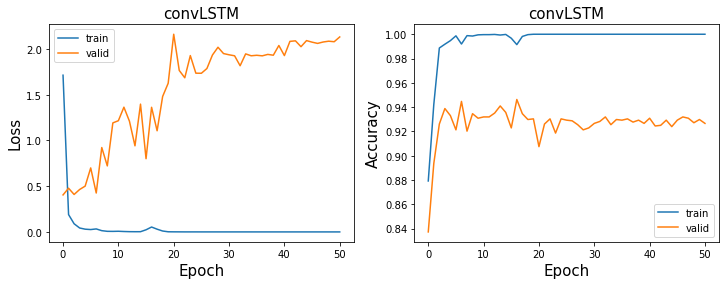

In [27]:
train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]
 
for epoch in range(num_epochs):
    train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
    val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, epoch))
#     elif verbose:
    else:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
#     if epoch == num_epochs-1:
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [28]:
train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow)
print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_trainresult.pt


In [29]:
train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

pickle.dump( train_result, open( train_result_filename, "wb" ) )

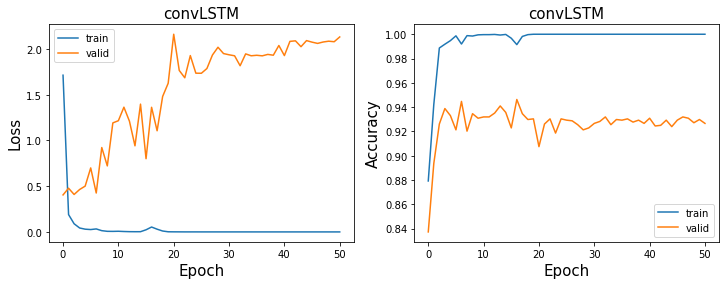

In [30]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [34]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CHall_' in s and reg_alpha in s and 'trainresult' not in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          0


/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_EPOCH0.pt


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.4046546220779419 accuracy:0.8372340425531914


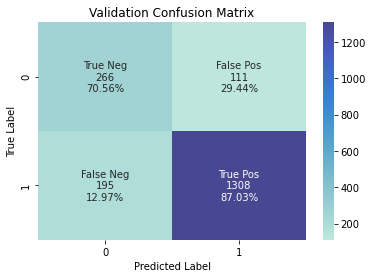

In [37]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM(input_dim = 62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)

    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    


## T-length = 5

In [66]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [67]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [68]:
## Upsample train
train_files = upsample(train_files)

In [69]:
len(train_files), len(val_files), len(test_files)

(6092, 1880, 1870)

In [70]:
## Load files to dataloader
T_length = 5

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=T_length, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

### Training

In [71]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
# verbose = False


model = convLSTM(input_dim = 62).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 2.7107160091400146
Val loss for epoch 0: 0.6468703746795654
1
Train loss for epoch 1: 0.1922268271446228
Val loss for epoch 1: 0.426085501909256
2
Train loss for epoch 2: 0.09021126478910446
Val loss for epoch 2: 0.2594897150993347
Train loss for epoch 3: 0.06056136637926102
Val loss for epoch 3: 0.5183616876602173
Train loss for epoch 4: 0.025786777958273888
Val loss for epoch 4: 1.0123772621154785
Train loss for epoch 5: 0.016337847337126732
Val loss for epoch 5: 0.8148128390312195
Train loss for epoch 6: 0.008886650204658508
Val loss for epoch 6: 1.0203016996383667
Train loss for epoch 7: 0.008547580800950527
Val loss for epoch 7: 0.9908741116523743
Train loss for epoch 8: 0.006728300824761391
Val loss for epoch 8: 1.030293345451355
Train loss for epoch 9: 0.004815795458853245
Val loss for epoch 9: 1.0164833068847656
Train loss for epoch 10: 0.005246938671916723
Val loss for epoch 10: 1.4469190835952759
Train loss for epoch 11: 0.004981077276170254
Val loss

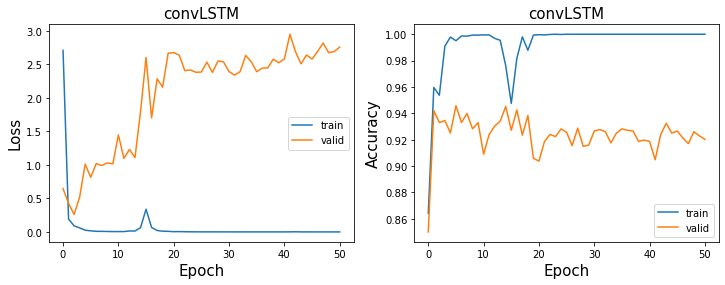

In [72]:
train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]
 
for epoch in range(num_epochs):
    train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
    val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, epoch))
#     elif verbose:
    else:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
#     if epoch == num_epochs-1:
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [73]:
train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length)
print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH5_trainresult.pt


In [74]:
train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

pickle.dump( train_result, open( train_result_filename, "wb" ) )

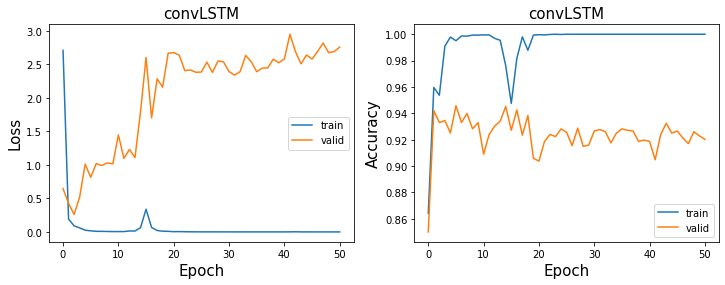

In [75]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [76]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
tlength = 'TLENGTH'+str(T_length)
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CHall_' in s and reg_alpha in s and 'trainresult' not in s and tlength in s and 'valcm' not in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          2


/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH5_EPOCH2.pt


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.2594897150993347 accuracy:0.9329787234042554
/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH5_valcm.pt


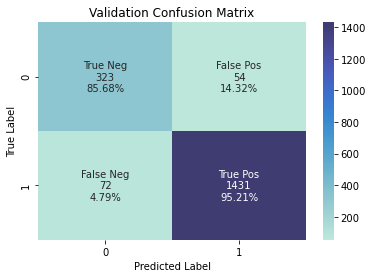

In [77]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM(input_dim = 62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    


## T-length = 10

In [54]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [55]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [56]:
## Upsample train
train_files = upsample(train_files)

In [57]:
len(train_files), len(val_files), len(test_files)

(6092, 1880, 1870)

In [58]:
## Load files to dataloader
T_length = 10

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=T_length, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

### Training

In [59]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
# verbose = False


model = convLSTM(input_dim = 62).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 1.0977524518966675
Val loss for epoch 0: 0.2783173620700836
Train loss for epoch 1: 0.2655906677246094
Val loss for epoch 1: 0.38908395171165466
Train loss for epoch 2: 0.1706017553806305
Val loss for epoch 2: 0.3194897472858429
Train loss for epoch 3: 0.11725962162017822
Val loss for epoch 3: 0.5443140864372253
Train loss for epoch 4: 0.08856134861707687
Val loss for epoch 4: 0.2913297414779663
Train loss for epoch 5: 0.12059682607650757
Val loss for epoch 5: 0.9063897132873535
Train loss for epoch 6: 0.057938896119594574
Val loss for epoch 6: 1.0641851425170898
Train loss for epoch 7: 0.027180295437574387
Val loss for epoch 7: 1.1265796422958374
Train loss for epoch 8: 0.02892034873366356
Val loss for epoch 8: 0.39243316650390625
Train loss for epoch 9: 0.017643693834543228
Val loss for epoch 9: 1.7489062547683716
Train loss for epoch 10: 0.010497262701392174
Val loss for epoch 10: 1.2505872249603271
Train loss for epoch 11: 0.0054468270391225815
Val loss fo

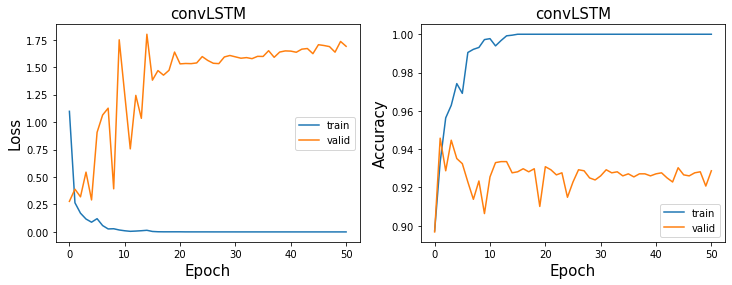

In [60]:
train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]
 
for epoch in range(num_epochs):
    train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
    val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, epoch))
#     elif verbose:
    else:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
#     if epoch == num_epochs-1:
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [61]:
train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length)
print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_trainresult.pt


In [62]:
train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

pickle.dump( train_result, open( train_result_filename, "wb" ) )

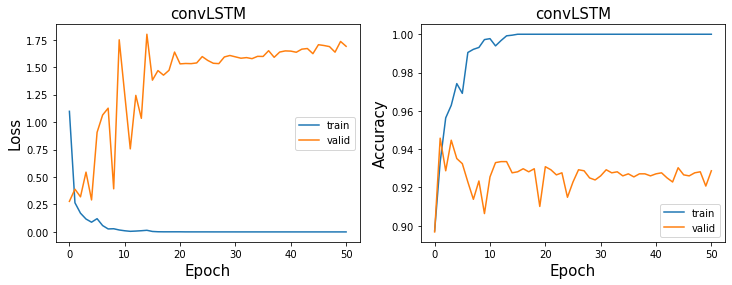

In [63]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [64]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
tlength = 'TLENGTH'+str(T_length)
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CHall_' in s and reg_alpha in s and 'trainresult' not in s and tlength in s and 'valcm' not in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          0


/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_EPOCH0.pt


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.2783173620700836 accuracy:0.8968085106382979
/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_valcm.pt


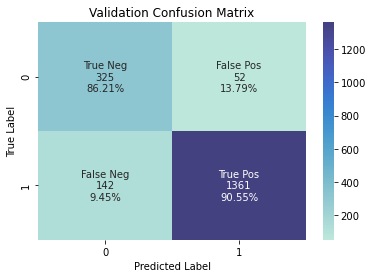

In [65]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM(input_dim = 62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    
